In [3]:
import numpy as np
import pandas as pd
from environment.tetris import Tetris
from agents.DumbAgent import DumbAgent
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
import seaborn as sns
import os

sns.set_theme()
np.random.seed(42)
os.makedirs("results", exist_ok=True)

c:\Python312\Lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [4]:
max_steps = 250
num_games = 1

In [5]:
def play_game(env, agent):
    env.reset()
    total_reward = 0
    for _ in range(max_steps):
        next_states = env.get_possible_states()
        best_action = agent.act(next_states)
        done, score, reward = env.step(*best_action)
        total_reward += reward

        if done:
            break

    return total_reward


def play_single_game(weights):
    env = Tetris(10, 20)
    agent = DumbAgent(5, None, weights=weights)
    return play_game(env, agent)

In [ ]:
space = [
    Real(-1, 1, name="cleared_lines"),
    Real(-1, 1, name="holes"),
    Real(-1, 1, name="bumpiness"),
    Real(-1, 1, name="max_height"),
    Real(-1, 1, name="check_pillar"),
]

@use_named_args(space)
def objective_function_named(**params):
    # Convert dictionary to list in the expected order
    weights = np.array([params[dim.name] for dim in space])

    if num_games == 1:
        return -play_single_game(weights)

    with Pool(processes=min(num_games, cpu_count())) as pool:
        results = pool.map(play_single_game, [weights for _ in range(num_games)])

    mean_reward = np.mean(results)
    print(f"Average reward: {mean_reward:.2f}")

    return -mean_reward

result = gp_minimize(
        objective_function_named,
        space,
        n_calls=200,  # Total evaluations (includes n_initial_points)
        n_initial_points=10,  # Initial random evaluations
        acq_func="EI",  # Expected Improvement
        n_jobs=-1,  # Use all available cores
        verbose=False,
    )

optimal_weights = [result.x[i] for i in range(len(space))]
for name, value in zip([dim.name for dim in space], optimal_weights):
    print(f"{name}: {value:.6f}")

cleared_lines: -0.981255
holes: -0.957652
bumpiness: -0.360455
max_height: -0.991781
check_pillar: -0.608442


In [7]:
np.save("results/optimal_weights.npy", np.array(optimal_weights))

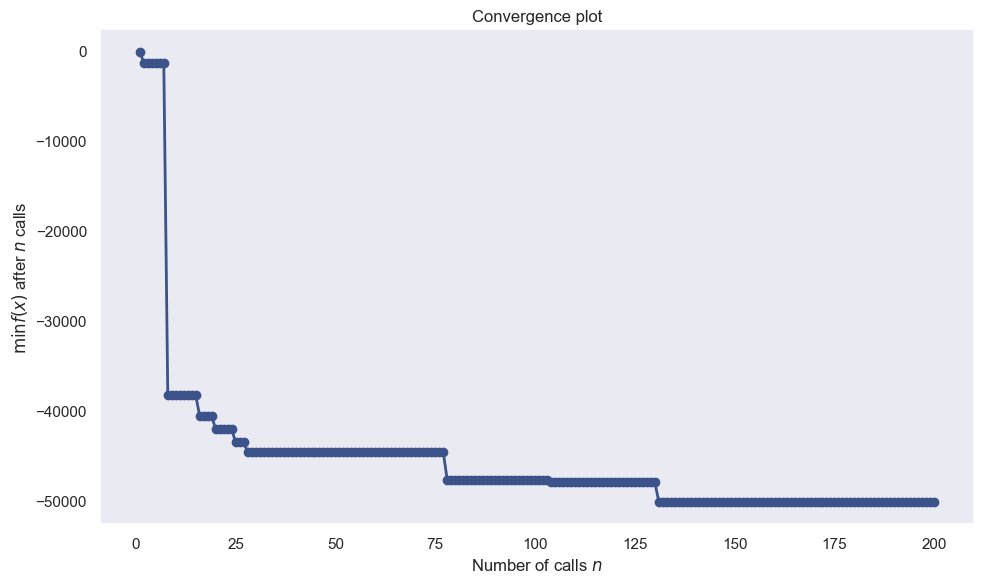

<Figure size 1200x1000 with 0 Axes>

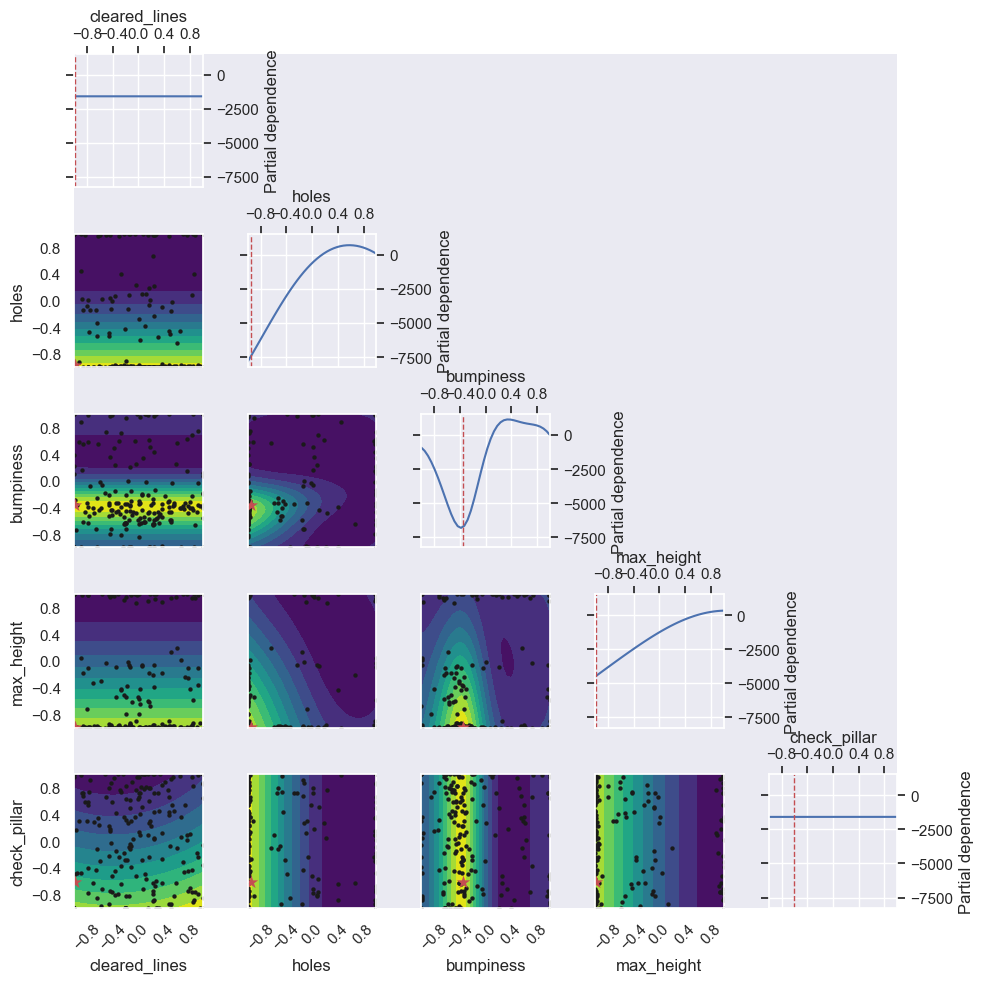

<Figure size 1200x1000 with 0 Axes>

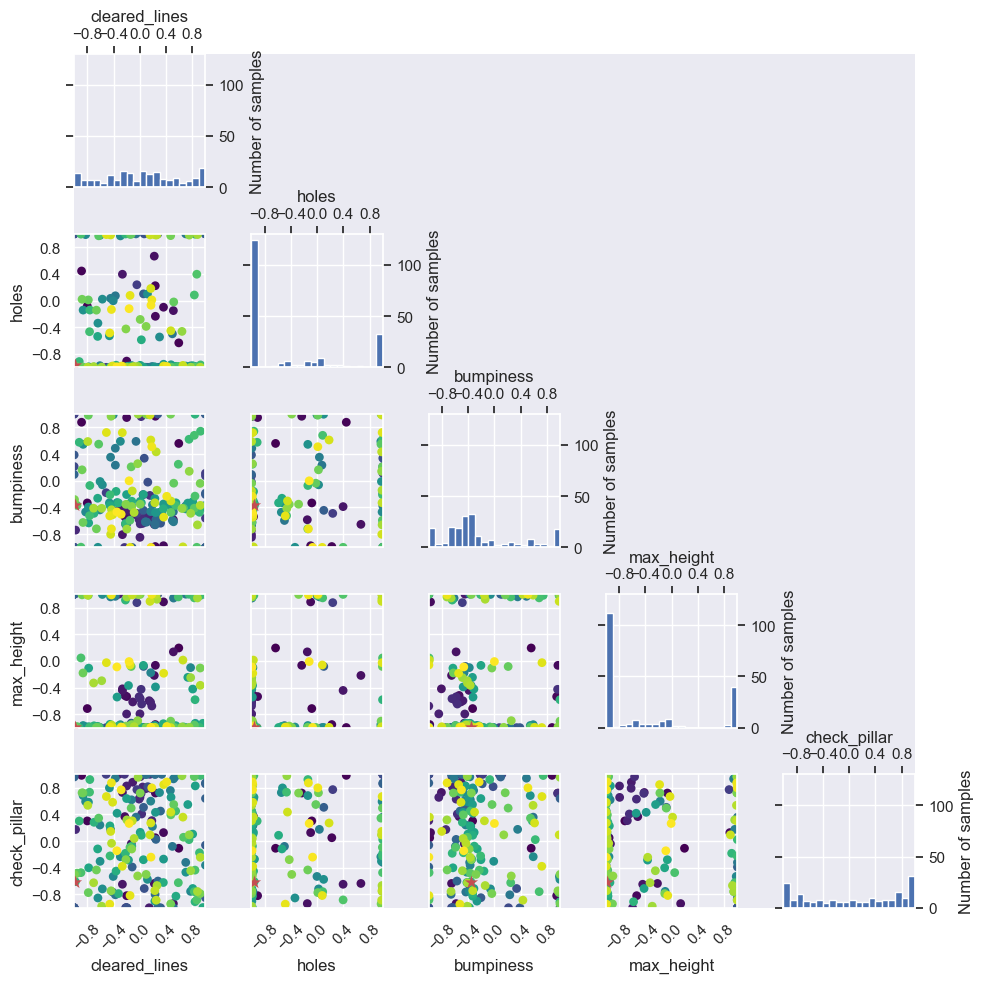

In [8]:
plt.figure(figsize=(10, 6))
plot_convergence(result)
plt.tight_layout()
plt.savefig("results/convergence.png")

# Plot and save objective function
plt.figure(figsize=(12, 10))
plot_objective(result)
plt.tight_layout()
plt.savefig("results/objective.png")

# Plot and save evaluations
plt.figure(figsize=(12, 10))
plot_evaluations(result)
plt.tight_layout()
plt.savefig("results/evaluations.png")

# Save detailed report
with open("results/report.txt", "w") as f:
    f.write(f"Number of evaluations: {len(result.x_iters)}\n")
    f.write(f"Best score: {-result.fun:.6f}\n")
    f.write("Optimal weights:\n")
    for name, value in zip([dim.name for dim in space], result.x):
        f.write(f"{name}: {value:.6f}\n")
    f.write("\nAll evaluations:\n")
    for i, (x, y) in enumerate(zip(result.x_iters, result.func_vals)):
        f.write(f"Iteration {i+1}: score={-y:.6f}, params={x}\n")

eval_df = pd.DataFrame(
    [list(x) + [-y] for x, y in zip(result.x_iters, result.func_vals)],
    columns=[dim.name for dim in space] + ["reward"],
)
eval_df.to_csv("results/evaluations.csv", index=False)